In [2]:
import numpy as np
import pickle

from scipy import signal
from scipy import ndimage
import scipy.optimize as opt;
import scipy.fft as fft

import torch
import torch.nn as nn
import torch.optim as optim

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import animation, rc

from IPython.display import HTML
%matplotlib inline

# Import custom modules
from lib.FramesDataset import FramesDataset
from lib import network

# Global variables
HIDDEN_UNITS = 1600
FRAME_SIZE = 20
WARMUP = 4
MODE = 'hierarchical'
T_STEPS = 20

PATHS = [
    # Clamped units
    './models/model-hierarchicalmode-15framesize-20tsteps-4warmup-2000epochs-1600units-0.001lr-0.25gradclip-1e-06L1-0.5beta-20210220-000132',
    # Absolute values
    './models/model-hierarchicalmode-15framesize-20tsteps-4warmup-2000epochs-1600units-0.001lr-0.25gradclip-1e-06L1-0.5beta-20210220-210621',
    # Absolute values 45 frames
    './models/model-hierarchicalmode-15framesize-45tsteps-4warmup-2000epochs-1600units-0.001lr-0.25gradclip-1e-06L1-0.5beta-20210223-180522',
    # Absolute values 45 frames, 20 frame size (162400)
    './models/model-hierarchicalmode-20framesize-45tsteps-4warmup-1000epochs-1600units-1e-05lr-0.25gradclip-1e-06L1-0.3beta-20210224-233528',
    './models/model-hierarchicalmode-20framesize-45tsteps-4warmup-2000epochs-1600units-1e-05lr-0.25gradclip-1e-06L1-0.3beta-20210225-140304'
]
PATH = PATHS[4]

# Set device to use on network
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using", DEVICE)

# Load previously trained model
model = network.RecurrentTemporalPrediction.load(
    hidden_units = HIDDEN_UNITS,
    frame_size = FRAME_SIZE,
    warmup = WARMUP,
    mode = MODE,
    path = PATH + '.pt'
)

# Load dataset
#train_dataset = FramesDataset('./datasets/processed_dataset_15px_20tsteps.npy', 'train', WARMUP)
#train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128)
#print("Training dataset length:", len(train_dataset))

Using cuda


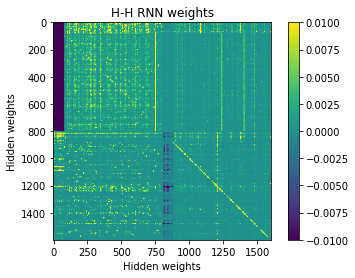

In [4]:
# Plot weight matrices
plt.imshow(model.rnn.weight_hh_l0.to(DEVICE).detach().numpy(), vmin=-0.01, vmax=0.01)
plt.xlabel('Hidden weights')
plt.ylabel('Hidden weights')
plt.title("H-H RNN weights")
plt.colorbar()
plt.show()

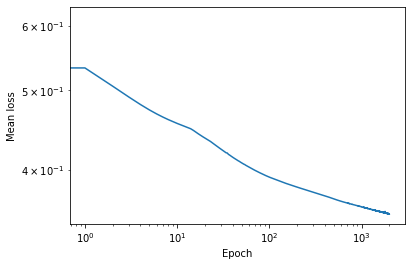

In [7]:
# Plot loss history
with open(PATHS[3] + '.pickle', 'rb') as p:
    loss_history_1 = pickle.load(p)
with open(PATHS[4] + '.pickle', 'rb') as p:
    loss_history_2 = pickle.load(p)

loss_history = np.concatenate([loss_history_1, loss_history_2])
    
plt.loglog(loss_history);
plt.xlabel('Epoch')
plt.ylabel('Mean loss')
plt.show() 

In [6]:
# Produce spike-triggered average
def max_abs_normalize (arr):
    return arr / np.max(np.abs(arr))

def normalize (arr):
    return np.array([
        (lambda a: (a-np.mean(a)) / np.std(a))(b)
        for b in arr
    ])

n_rand_stimuli = 500

stimuli = {}
unit_activity = {}

for i in range(HIDDEN_UNITS):
    stimuli[i] = []
    unit_activity[i] = []

for i in range(n_rand_stimuli):
    if i % 10 == 9:
        print('Trial {}'.format(i+1))
    
    noise_shape = (1, WARMUP+20, FRAME_SIZE**2)
    noise = np.random.normal(loc=0, scale=1, size=noise_shape)
    noise = torch.Tensor(noise).to(DEVICE)
    
    _, hidden_state = model(noise)
    
    for t_step in range(WARMUP, WARMUP+20):
        units = hidden_state[0, t_step, :] # Output t_step
        for i, unit in enumerate(units):
            if unit > 0:
                weighted_stimulus = noise[0, t_step, :] * unit
                stimuli[i].append(weighted_stimulus.cpu().detach().numpy())
                unit_activity[i].append(unit.cpu().detach().numpy())

averaged_stimuli_group1 = [], []
averaged_stimuli_group2 = [], []

for i in range(HIDDEN_UNITS):
    if i % 100 == 99:
        print('Trial {}'.format(i+1))
    
    stimuli_len = len(stimuli[i])
    if stimuli_len:
        stimulus = np.sum(stimuli[i], 0)/np.sum(unit_activity[i]) # Weighted average

        if i < HIDDEN_UNITS//2:
            averaged_stimuli_group1[0].append(stimulus)
            averaged_stimuli_group1[1].append(i)
        else:
            averaged_stimuli_group2[0].append(stimulus)
            averaged_stimuli_group2[1].append(i)
averaged_stimuli_group1 = np.array(averaged_stimuli_group1[0]), np.array(averaged_stimuli_group1[1])
averaged_stimuli_group2 = np.array(averaged_stimuli_group2[0]), np.array(averaged_stimuli_group2[1])
        
print('Finished averaging stimuli')

Trial 10
Trial 20
Trial 30
Trial 40
Trial 50
Trial 60
Trial 70
Trial 80
Trial 90
Trial 100
Trial 110
Trial 120
Trial 130
Trial 140
Trial 150
Trial 160
Trial 170
Trial 180
Trial 190
Trial 200
Trial 210
Trial 220
Trial 230
Trial 240
Trial 250
Trial 260
Trial 270
Trial 280
Trial 290
Trial 300
Trial 310
Trial 320
Trial 330
Trial 340
Trial 350
Trial 360
Trial 370
Trial 380
Trial 390
Trial 400
Trial 410
Trial 420
Trial 430
Trial 440
Trial 450
Trial 460
Trial 470
Trial 480
Trial 490
Trial 500
Trial 100
Trial 200
Trial 300
Trial 400
Trial 500
Trial 600
Trial 700
Trial 800
Trial 900
Trial 1000
Trial 1100
Trial 1200
Trial 1300
Trial 1400
Trial 1500
Trial 1600
Finished averaging stimuli


Text(-0.025, 0.5, 'Postsynaptic unit')

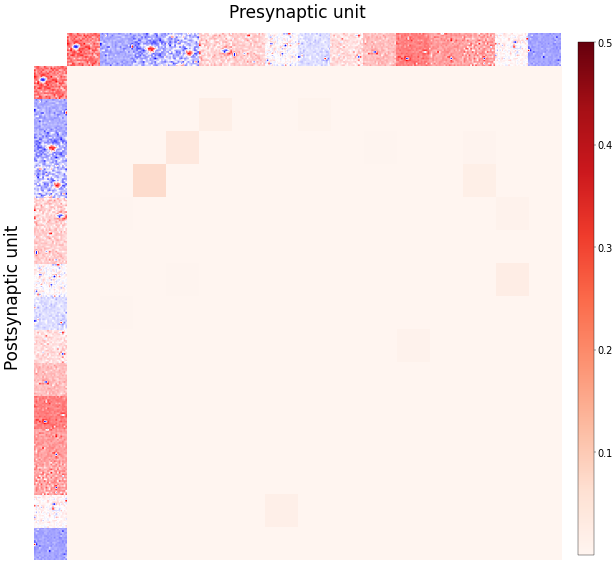

In [17]:
# Visualise connections between recurrent units

starting_idx = 80
n_units = 15
units_slice = slice(starting_idx, starting_idx+n_units)

hh_indices = averaged_stimuli_group1[1][units_slice]
hh_weights = model.rnn.weight_hh_l0.cpu().detach().numpy()
hh_weights_subset = np.zeros(shape=(n_units, n_units))

for row in range(n_units):
    for col in range(n_units):
        hh_weights_subset[row, col] = hh_weights[hh_indices[row], hh_indices[col]]

sta_RFs = max_abs_normalize(averaged_stimuli_group1[0][units_slice])

cols = n_units + 1
rows = n_units + 1

fig, f_axs = plt.subplots(
    dpi=35,
    ncols=cols,
    nrows=rows,
    figsize=(cols, rows),
    gridspec_kw=dict(wspace=0.0, hspace=0.0,
                     top=1. - 0.5 / (rows + 1), bottom=0.5 / (rows + 1),
                     left=0.5 / (cols + 1), right=1 - 0.5 / (cols + 1)),
)
gs = f_axs[0, 0].get_gridspec()

for axs in f_axs[1:, 1:]:
    for ax in axs:
        ax.remove()
axbig = fig.add_subplot(gs[1:, 1:])
axbig.set_axis_off()
im = axbig.imshow(hh_weights_subset, cmap='Reds', vmax=.5)

cbaxes = fig.add_axes([1, 0.04, 0.03, 0.915]) 
cb = plt.colorbar(im, cax = cbaxes)
for t in cb.ax.get_yticklabels():
    t.set_fontsize(20)

count = 0
for ax_row in f_axs:
    for ax in ax_row:
        ax.set_axis_off()
        
        if count > 0 and count < n_units+1: # X-axis row
            unit_n = count-1
        elif count % (n_units+1) == 0: # Y-axis row
            unit_n = count//(n_units+1) - 1
        else:
            unit_n = -1
            
        if unit_n > -1:
            unit = np.reshape(sta_RFs[unit_n], (FRAME_SIZE, FRAME_SIZE))
            ax.imshow(unit, cmap='bwr')
            
        count += 1
        
fig.text(0.5, 1, 'Presynaptic unit', ha='center', fontsize=35)
fig.text(-0.025, 0.5, 'Postsynaptic unit', va='center', rotation='vertical', fontsize=35)

In [35]:
# Virtual physiology

def plot_grating_animation (gratings):
    fig = plt.figure(dpi=40)
    init_data = gratings.detach().numpy()[0, 0].reshape(FRAME_SIZE, FRAME_SIZE)
    im = plt.imshow(init_data, cmap='gray')
    plt.title("Grating stimulus", size=20)
    def animate(i):
        im_data = gratings.detach().numpy()[0, i].reshape(FRAME_SIZE, FRAME_SIZE)
        im.set_array(im_data)
        return [im]
    anim = animation.FuncAnimation(
        fig, animate,
        frames=WARMUP+T_STEPS, interval=100
    )
    return anim

def get_f_value (activity):
    # Fit to sine
    def func(x, a, b, c, d):
        return a*np.sin(b*x + c) + d

    params = []
    mse = []
    increment = []

    offset = 0

    for i in range(0, 50, 5):
        x = np.arange(len(activity[offset:]))
        y = np.array(activity[offset:]) + i

        # In case it fails to find optimal parameters
        try:
            bounds = (
                [-np.inf, 1, -np.inf, -np.inf],
                [np.inf, 4, np.inf, np.inf]
            )
            
            optimizedParameters, pcov = opt.curve_fit(func, x, y, method='trf', bounds=bounds);
            y_est = func(x, *optimizedParameters)
            params.append(optimizedParameters)
            mse.append(np.mean(np.sum((y-y_est)**2)))
            increment.append(i)
        except:
            continue

    if len(params):
        idx = np.argmin(mse)
        best_params = params[idx]
        best_i = increment[idx]

        y_est = func(x, *best_params) - best_i
        x = np.arange(len(activity))
        y = np.array(activity)

        f0 = np.mean(activity)
        f1 = (abs(best_params[0]))
        f = f1/f0

        return f
    else:
        return False

def generate_gratings (frequency, rotation):
    gratings = []
    count = 0
    for i in range(WARMUP+T_STEPS+1):
        extended_val = 4
        extended_size = FRAME_SIZE*extended_val
        crop_slice = slice(
            (extended_size-FRAME_SIZE)//2, (extended_size-FRAME_SIZE)//2+FRAME_SIZE
        )
        
        phase = np.pi*count

        x_range = np.linspace(0, 2*np.pi, num=extended_size)
        y = np.sin(x_range*frequency*extended_val + phase)

        grating = np.repeat(y, extended_size, axis=0).reshape((extended_size, extended_size))
        grating = ndimage.rotate(grating, rotation, reshape=False)
        grating = grating[crop_slice, crop_slice]
        grating = grating.reshape(FRAME_SIZE**2)
        gratings.append(grating)
    
        count -= 0.5
    gratings = np.array([gratings])
    gratings = torch.Tensor(gratings).to(DEVICE)

    return gratings

physiology_data_group2 = []
SHOW_GRAPHS = False

group_data = averaged_stimuli_group2
units_len = len(group_data[1])
for i in range(units_len):
    
    data = {}

    unit_STA_idx = i # Index out of those units that have STA RF
    unit_idx = group_data[1][unit_STA_idx] # Index out of whole populations
    
    data["unit_idx"] = unit_idx
    
    # Plot STA RF estimate
    if SHOW_GRAPHS:
        sta = normalize(group_data[0])[unit_STA_idx]
        fig = plt.figure(dpi=40)
        plt.imshow(sta.reshape(FRAME_SIZE, FRAME_SIZE), cmap='gray')
        plt.title('Normalized SA', size=25)
        plt.show()

    # Grid search for optimal grating orientation and spatial frequency
    spatial_frequencies = np.arange(0.5, 6.5, 0.5)
    orientations = np.arange(0, 190, 10)
    responses = np.zeros((len(spatial_frequencies), len(orientations)))
    for row, sf in enumerate(spatial_frequencies):
        for col, deg in enumerate(orientations):
            gratings = generate_gratings(sf, deg)
            activity = []

            _, hidden_state = model(gratings)
            for t_step in range(WARMUP, WARMUP+T_STEPS):
                unit = hidden_state[0, t_step, unit_idx]
                activity.append(unit.cpu().detach().numpy())

            responses[row, col] = max(activity)
            
    data["tuning_curve"] = responses
            
    if SHOW_GRAPHS:
        fig, ax = plt.subplots(dpi=100)
        plt.imshow(responses)
        plt.colorbar()
        plt.xlabel("Orientation")
        plt.xticks(range(len(orientations)), orientations, size=6) 
        plt.ylabel("SF")
        plt.yticks(range(len(spatial_frequencies)), spatial_frequencies, size=6)
        plt.title("Max unit activity as a function of orientation and SF", size=8)
        plt.show()

    # Plot response of neuron over time for optimal SF and orientation
    sf_idx, orient_idx = np.where(responses >= np.max(responses))
    max_sf, max_orient = spatial_frequencies[sf_idx[0]], orientations[orient_idx[0]]
    gratings = generate_gratings(max_sf, max_orient)
    activity = []
    
    _, hidden_state = model(gratings)
    for t_step in range(WARMUP, WARMUP+T_STEPS):
        unit = hidden_state[0, t_step, unit_idx]
        activity.append(unit.cpu().detach().numpy())

    
    data["sf"] = max_sf
    data["orientation"] = max_orient
    data["response_graph"] = activity
        
    if SHOW_GRAPHS:
        fig = plt.figure()
        plt.plot(activity)
        plt.xlabel("Frame (phase)")
        plt.ylabel("Activity")
        plt.title("Activity for SF = {}, orientation = {}, unit {}".format(max_sf, max_orient, unit_idx))
        plt.show()
    
    f_value = get_f_value(activity)
    data["f"] = f_value
    
    physiology_data_group2.append(data)
    
    if i % 10 == 9:
        print("Unit {} / {}".format(i+1, units_len))

Unit 10 / 257
Unit 20 / 257
Unit 30 / 257
Unit 40 / 257
Unit 50 / 257
Unit 60 / 257
Unit 70 / 257
Unit 80 / 257
Unit 90 / 257
Unit 100 / 257


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in double_scalars


Unit 110 / 257
Unit 120 / 257
Unit 130 / 257
Unit 140 / 257
Unit 150 / 257
Unit 160 / 257
Unit 170 / 257
Unit 180 / 257
Unit 190 / 257
Unit 200 / 257
Unit 210 / 257
Unit 220 / 257
Unit 230 / 257
Unit 240 / 257
Unit 250 / 257


In [36]:
with open('./virtual_physiology/group2-hierarchicalmode-20framesize-45tsteps-4warmup-2000epochs-1600units-1e-05lr-0.25gradclip-1e-06L1-0.3beta-20210225-140304', 'wb') as handler:
    pickle.dump(physiology_data_group2, handler)

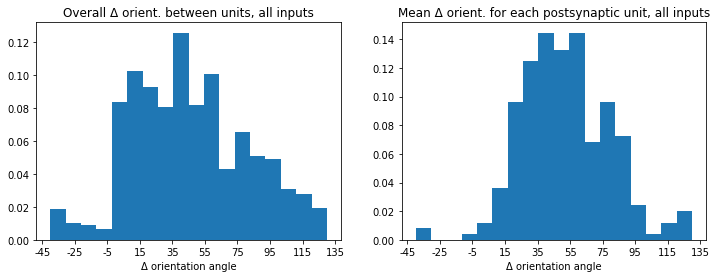

[Text(0, 0, '-45'),
 Text(0, 0, '-25'),
 Text(0, 0, '-5'),
 Text(0, 0, '15'),
 Text(0, 0, '35'),
 Text(0, 0, '55'),
 Text(0, 0, '75'),
 Text(0, 0, '95'),
 Text(0, 0, '115'),
 Text(0, 0, '135')]

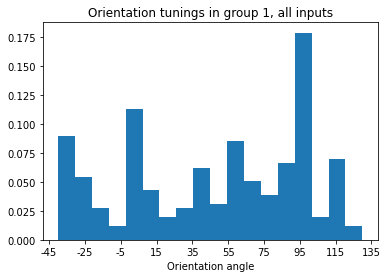

In [40]:
# Plot distribution of connections

# Get subset of weights for those units which have STA estimates
weights = model.rnn.weight_hh_l0.cpu().detach().numpy()
unit_idxs = averaged_stimuli_group2[1]
unit_idxs_inhib = averaged_stimuli_group2[1][:72]
unit_idxs_excit = averaged_stimuli_group2[1][72:]
weights_subset = weights[unit_idxs, :] # Rows
weights_subset = weights_subset[:, unit_idxs] # Columns

np.random.shuffle(weights_subset)
np.random.shuffle(np.transpose(weights_subset))

# Normalize weights and find threshold (greater than 2 std's)
weights_subset = (weights_subset-np.mean(weights_subset)) / np.std(weights_subset)
threshold = 1

orientation_deltas = []
mean_orientation_deltas = []

for post_unit_idx in range(len(unit_idxs)):
    unit_orientation_deltas = []
    for pre_unit_idx in range(len(unit_idxs)):
        if abs(weights_subset[post_unit_idx, pre_unit_idx]) >= threshold:
            pre_unit = physiology_data_group1[pre_unit_idx]
            post_unit = physiology_data_group1[post_unit_idx]
            
            a1, a2 = pre_unit["orientation"], post_unit["orientation"]
            adelta = 180 - abs(abs(a1 - a2) - 180)
            orientation_deltas.append(adelta)
            unit_orientation_deltas.append(adelta)
    if len(unit_orientation_deltas):
        mean_orientation_deltas.append(np.mean(unit_orientation_deltas))

orientation_deltas = np.array(orientation_deltas)
mean_orientation_deltas = np.array(mean_orientation_deltas)
        
shift = 45
        
    
shifted_orientation_deltas = (orientation_deltas+shift)%180
shifted_mean_orientation_deltas = (mean_orientation_deltas+shift)%180

weights_ods = np.ones_like(shifted_orientation_deltas) / float(len(orientation_deltas))
weights_shifted_ods = np.ones_like(shifted_mean_orientation_deltas) / float(len(mean_orientation_deltas))
    
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(1/3))
axs[0].hist(shifted_orientation_deltas, bins=18, weights=weights_ods)
axs[0].set_title("Overall Δ orient. between units, all inputs")
axs[0].set_xlabel("Δ orientation angle")
axs[0].set_xticks(np.arange(0, 200, 20))
axs[0].set_xticklabels(np.arange(0-shift, 200-shift, 20))

axs[1].hist(shifted_mean_orientation_deltas, bins=18, weights=weights_shifted_ods)
axs[1].set_title("Mean Δ orient. for each postsynaptic unit, all inputs")
axs[1].set_xlabel("Δ orientation angle")
axs[1].set_xticks(np.arange(0, 200, 20))
axs[1].set_xticklabels(np.arange(0-shift, 200-shift, 20))

plt.show()

orientations = []
for i in range(len(unit_idxs)):
    orientations.append(physiology_data_group1[i]["orientation"])
orientations = np.array(orientations)
weights = np.ones_like(orientations) / float(len(orientations))

fig, ax = plt.subplots()
ax.hist((orientations+shift)%180, bins=18, weights=weights)
ax.set_title("Orientation tunings in group 1, all inputs")
ax.set_xlabel("Orientation angle")
ax.set_xticks(np.arange(0, 200, 20))
ax.set_xticklabels(np.arange(0-shift, 200-shift, 20))

Text(0.5, 0.98, 'F values (> 1 indicates a simple cell)')

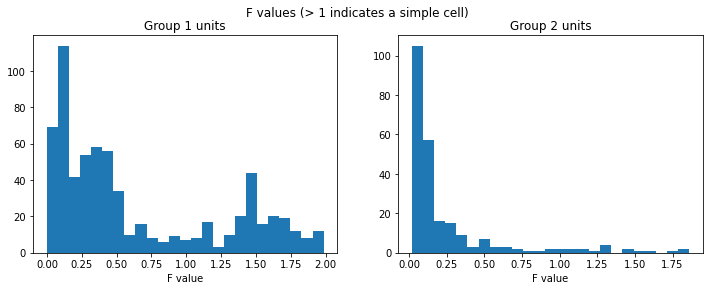

In [41]:
f_values_1 = []
for i in range(len(averaged_stimuli_group1[1])):
    f_values_1.append(physiology_data_group1[i]["f"])
f_values_1 = np.array(f_values_1)
f_values_1 = f_values_1[f_values_1 < 2]
    
f_values_2 = []
for i in range(len(averaged_stimuli_group2[1])):
    f_values_2.append(physiology_data_group2[i]["f"])
f_values_2 = np.array(f_values_2)
f_values_2 = f_values_2[f_values_2 < 2]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(1/3))
axs[0].hist(f_values_1, bins=25)
axs[0].set_title("Group 1 units")
axs[0].set_xlabel("F value")
axs[1].hist(f_values_2, bins=25)
axs[1].set_title("Group 2 units")
axs[1].set_xlabel("F value")
fig.suptitle('F values (> 1 indicates a simple cell)')

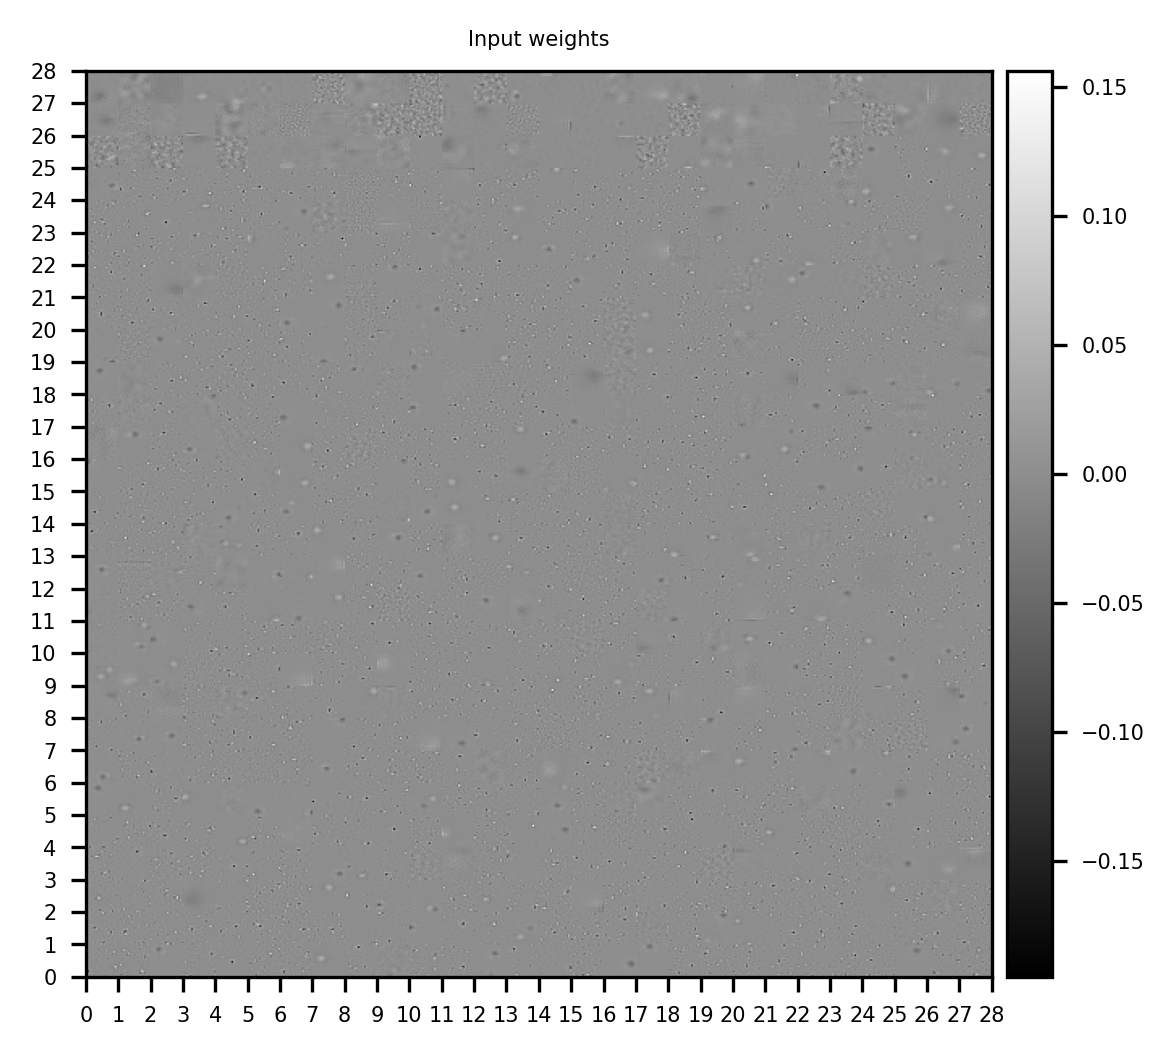

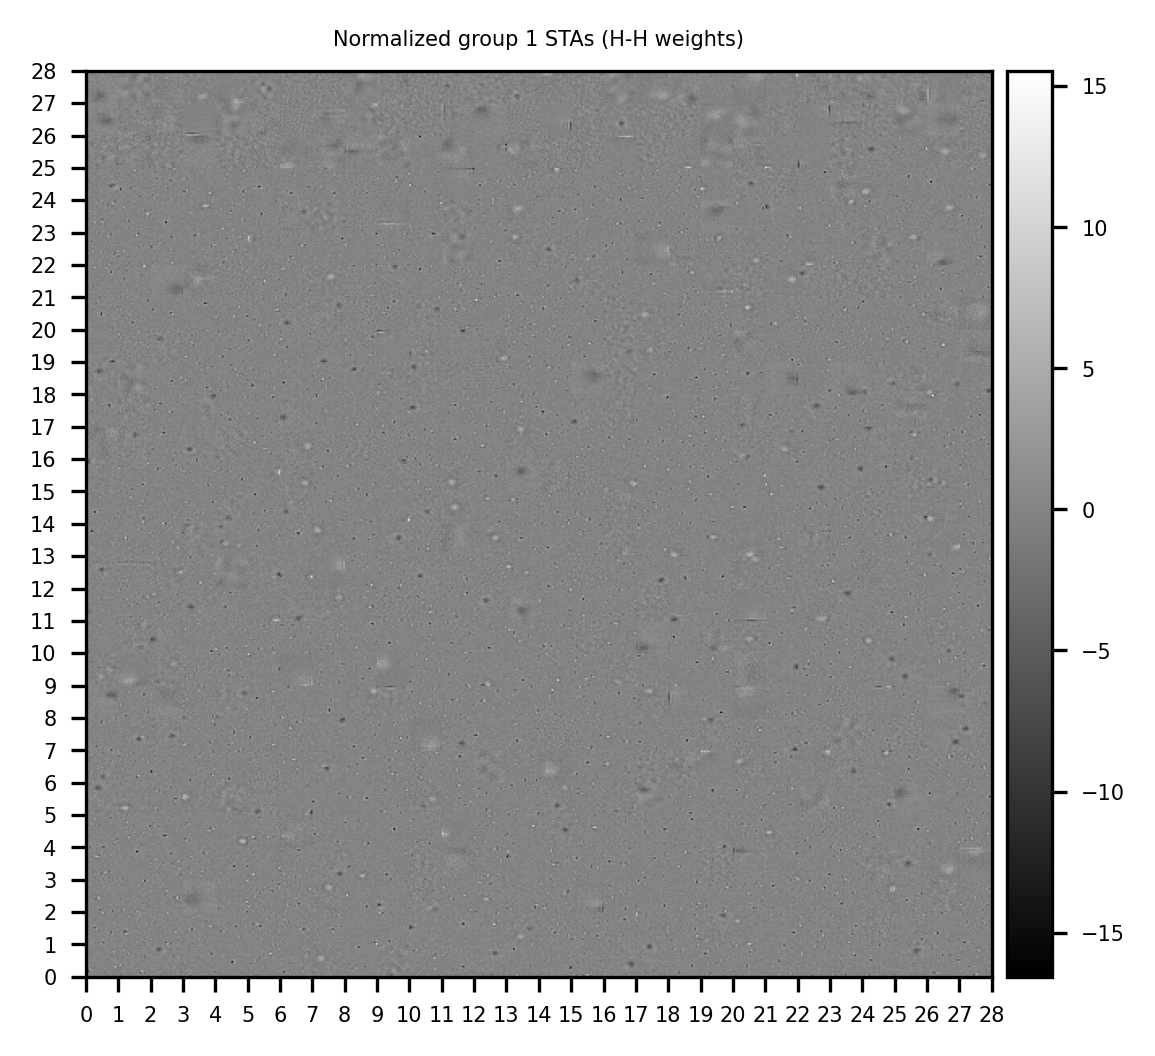

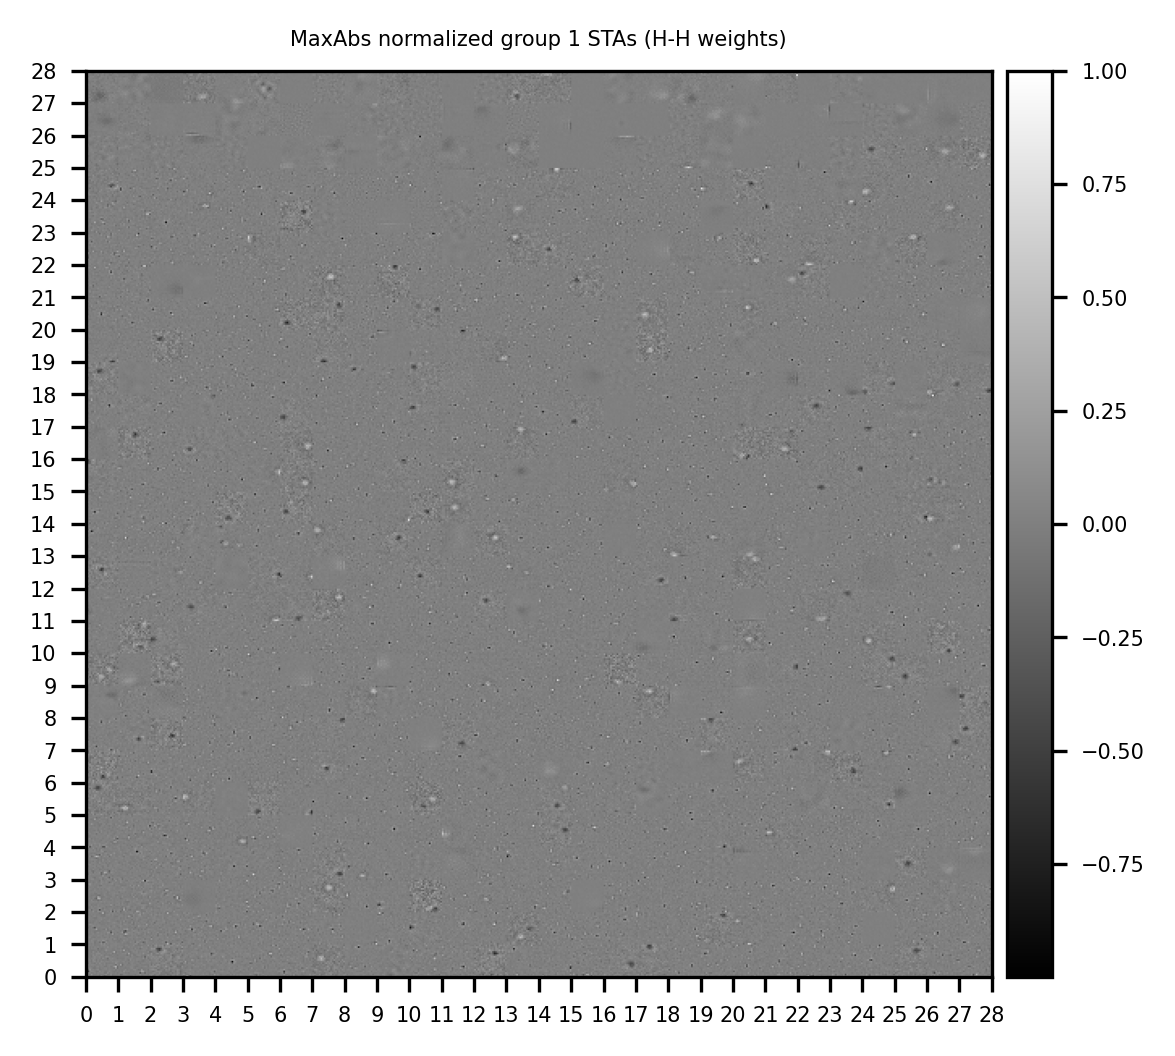

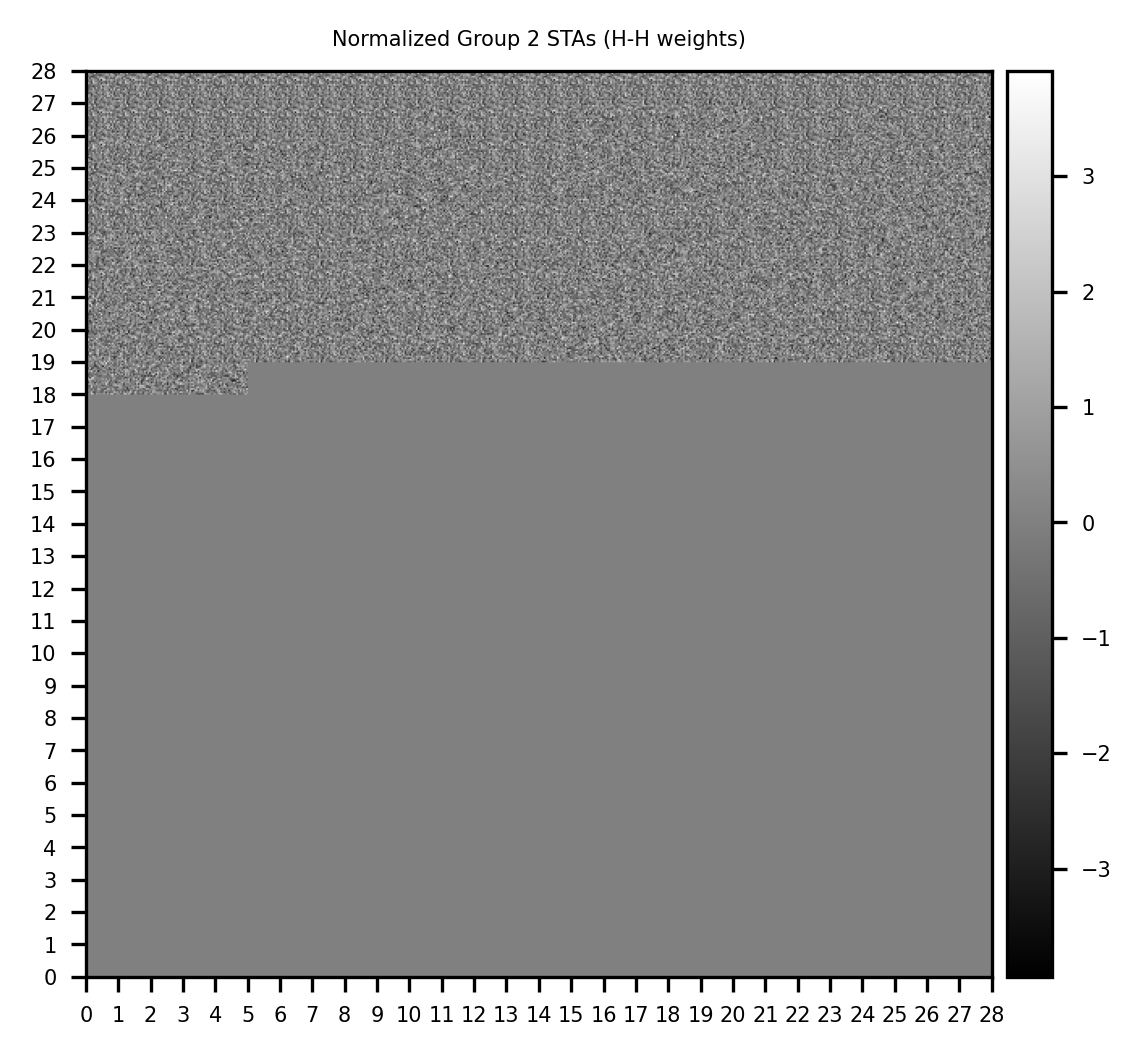

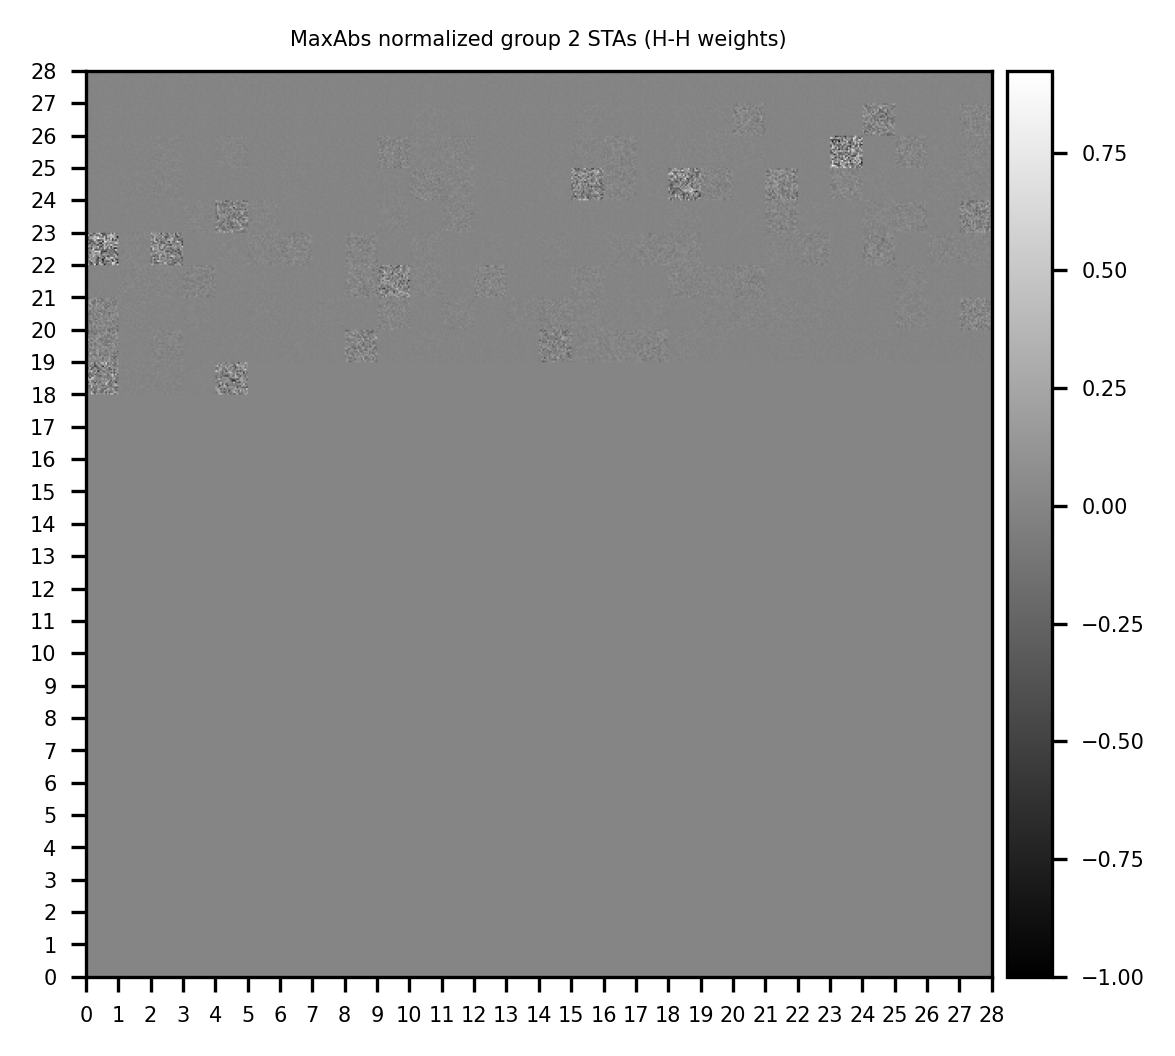

In [34]:
#Plot spike triggered averages and input weights
def plot_weights (weights_array, rows, columns, offset = 0, title = ""):
    font_size = 5
    weights = weights_array[offset:offset+rows*columns, :]
    im = np.zeros((rows*FRAME_SIZE, columns*FRAME_SIZE))
    
    for row in range(rows):
        for column in range(columns):
            idx = row*columns + column
            hidden_unit_weights = np.zeros(FRAME_SIZE**2) # Pad image if no more weights to show
            if idx < len(weights):
                hidden_unit_weights = weights[idx]
            hidden_unit_weights = np.reshape(hidden_unit_weights, (FRAME_SIZE, FRAME_SIZE))
            im[row*FRAME_SIZE:(row+1)*FRAME_SIZE, column*FRAME_SIZE:(column+1)*FRAME_SIZE] = hidden_unit_weights

    fig, ax = plt.subplots(dpi=300)
    im_plt = plt.imshow(im, extent=[0, columns, 0, rows], cmap='gray')
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cb_plt = plt.colorbar(im_plt, cax=cax)
    cb_plt.ax.tick_params(labelsize=font_size)

    ax.set_xticks(np.arange(0, columns+1))
    ax.set_xticklabels(np.arange(0, columns+1), size=font_size)
    ax.set_yticks(np.arange(0, rows+1))
    ax.set_yticklabels(np.arange(0, rows+1), size=font_size)
    #ax.grid(which='major', color='w', linestyle='-', linewidth=0.5)
    ax.set_title(title, size=font_size)

rows, columns, offset = (28, 28, 0)
plot_weights(model.rnn.weight_ih_l0.cpu().detach().numpy(), rows, columns, offset, "Input weights")

plot_weights(normalize(averaged_stimuli_group1[0]), rows, columns, offset, "Normalized group 1 STAs (H-H weights)")
plot_weights(max_abs_normalize(averaged_stimuli_group1[0]), rows, columns, offset, "MaxAbs normalized group 1 STAs (H-H weights)")
plot_weights(normalize(averaged_stimuli_group2[0]), rows, columns, offset, "Normalized Group 2 STAs (H-H weights)")
plot_weights(max_abs_normalize(averaged_stimuli_group2[0]), rows, columns, offset, "MaxAbs normalized group 2 STAs (H-H weights)")

In [14]:
# Visualise network predictions
x, y = train_dataset[0]
x = x.to(DEVICE)
y = y.to(DEVICE)
pred, _ = model(torch.unsqueeze(x, 0))
pred = torch.squeeze(pred, 0)

steps = 10

fig, axes = plt.subplots(1, steps, dpi=200)
for i in range(steps):
    im_y = y[WARMUP+i].view(FRAME_SIZE, FRAME_SIZE).detach().cpu().numpy()
    axes[i].imshow(im_y, cmap='gray')
    axes[i].axis('off')
axes[0].set_title('Target', size=7)
plt.show()

fig, axes = plt.subplots(1, steps, dpi=200)
for i in range(steps):
    im_pred = pred[i, :FRAME_SIZE**2].view(FRAME_SIZE, FRAME_SIZE).detach().cpu().numpy()
    axes[i].imshow(im_pred, cmap='gray')
    axes[i].axis('off')
axes[0].set_title('Predicted', size=7)
plt.show()

RuntimeError: input.size(-1) must be equal to input_size. Expected 400, got 225